In [1]:
'''Task:
Our company is not working efficiently! We spend way too much time
drafting documents and this needs to be fixed! @
For the company, you need to create an Al Agentic System that can
speed up drafting documents, emails, etc. The Al Agentic System
should have Human-Al Collaboration meaning the Human should be
able to able to provide continuous feedback and the Al Agent shoul
stop when the Human is happy with the draft. The system should 
be fast
nd be able to save the drafts.
able to save
'''

'Task:\nOur company is not working efficiently! We spend way too much time\ndrafting documents and this needs to be fixed! @\nFor the company, you need to create an Al Agentic System that can\nspeed up drafting documents, emails, etc. The Al Agentic System\nshould have Human-Al Collaboration meaning the Human should be\nable to able to provide continuous feedback and the Al Agent shoul\nstop when the Human is happy with the draft. The system should \nbe fast\nnd be able to save the drafts.\nable to save\n'

In [ ]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv  
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

c:\Users\mawiy\OneDrive\Desktop\Legal-Agent\myLegal\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [7]:
from langchain_google_genai import ChatGoogleGenerativeAI

In [ ]:
load_dotenv()

doc_content = ""

class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage], add_messages]

@tool
def update(content:str)-> str:
    '''Updates the document with the provided content.'''
    global doc_content
    doc_content=content
    return f"Document has been updated succesfully ,The cuurent content is \n {doc_content}"


@tool
def save(filename:str)-> str:
    '''saves the file in txt format and gives name to it  '''
    
    global doc_content
    
    if not filename.endswith('.txt'):
        filename=f"{filename}.txt"
        
    try:
        with open(filename, 'w') as file:
            file.write(doc_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."
    
    except Exception as e:
        return f"Error saving document: {str(e)}"
    
tools=[update,save]
    

In [ ]:
model=ChatGoogleGenerativeAI(model='gemini-2.5-flash').bind_tools(tools=tools)


In [ ]:
def our_agent (state:AgentState)->AgentState:
    systum_prompt=SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is:{doc_content}
    """)
    
    if not state['messages']:
        user_input="I am ready to update the Documnet"
        user_msg=HumanMessage(content=user_input)
        
        
    else :
        user_input=input("\n What would you like to write ")
        print("\n USER: {user_input}")
        
        user_msg=HumanMessage(content=user_input)
        
    all_messages=[systum_prompt]+[user_msg]+list(state["messages"])
    
    response= model.invoke(all_messages)
    
    
    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_msg, response]}

In [ ]:
def should_continue(state:AgentState)->AgentState:
    '''determines whether to continue or stay'''
    
    messages=state['messages']
    
    if not messages:
        return "continue"
    
    
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and 
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint
        
    return "continue"
    

In [20]:
graph=StateGraph(AgentState)

graph.add_node('agent',our_agent)
tool_node=ToolNode(tools=tools)
graph.add_node('tool',tool_node)


graph.set_entry_point('agent')

graph.add_edge('agent','tool')

graph.add_conditional_edges(
    "tool",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

app = graph.compile()


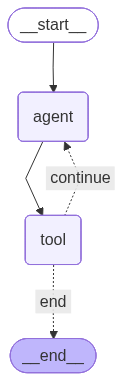

In [21]:
app

In [34]:
def run_document_agent():
    print("\n ===== DRAFTER =====")
    
    state = {"messages": []}
    
    for step in app.stream(state, stream_mode="values"):
        if "messages" in step:
            print_messages(step["messages"])
    
    print("\n ===== DRAFTER FINISHED =====")

if __name__ == "__main__":
    run_document_agent()


 ===== DRAFTER =====


NameError: name 'message' is not defined